In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.io.wavfile as wavfile

44100
(2845440, 2)


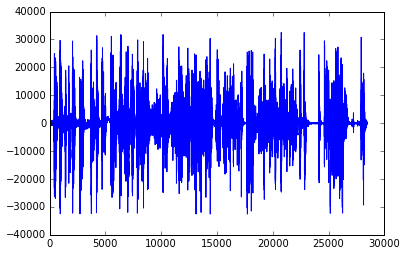

In [14]:
rate, piano = wavfile.read('piano.wav')
print(rate)
print(piano.shape)
plt.figure()
plt.plot(piano[0::100,0])

In [17]:
Nsec = np.floor(piano.shape[0]/rate).astype('int')
print(Nsec)

64


In [97]:
from numpy.fft import fft
from numpy import hamming, hanning
import scipy.signal as signal

def PianoFFT(yt, fs):
    dt = 1.0/fs
    Nt = len(yt)
    tt = np.arange(0, Nt*dt, dt)
    Nf = len(yt)
    df = fs / Nf
    ff = np.arange(0,fs,df)
    yf = np.abs(fft(yt*hanning(Nf)))
    plt.figure()
    plt.subplot(2,1,1)
    plt.plot(tt, yt)
    plt.subplot(2,1,2)
    plt.plot(ff,yf)
    plt.xlim([0,2000])
    
    return yf, ff
    
def PianoWelch(yt, fs):
    dt = 1.0/fs
    Nt = len(yt)
    tt = np.arange(0, Nt*dt, dt)
    Nf = len(yt)
    nperseg = np.round(fs/20)
    noverlap = np.round(nperseg/2)
    ff, yf = signal.welch(yt, fs=fs, nperseg=nperseg, noverlap=noverlap, nfft=Nf)
    yf = yf * nperseg
    plt.figure()
    plt.subplot(2,1,1)
    plt.plot(tt, yt)
    plt.subplot(2,1,2)
    plt.plot(ff2, yf2)
    plt.xlim([0,2000])
    
    return yf, ff

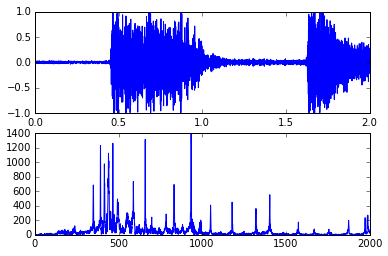

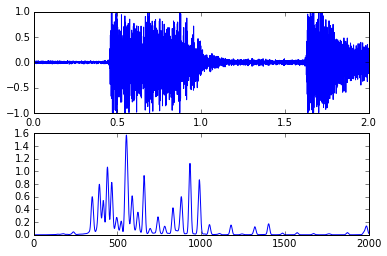

In [98]:
fs = 1.0*rate
for isec in range(1, 2):
    ileft = np.round((isec-0.5)*rate)
    iright = np.round((isec+1.5)*rate)
    y = piano[ileft:iright, 0].astype('float')
    y = y / 2**15
    
    yf, ff = PianoFFT(y, fs)
    PianoWelch(y, fs)

In [82]:
PianoKeyFreq = []
for n in range(1, 89):
    KeyFreq = 2**((n-49.0)/12.0) * 440.0
    PianoKeyFreq.append(KeyFreq)
PianoKeyFreq = np.asarray(PianoKeyFreq)
PianoKeyFreq.shape

df = ff[1] - ff[0]
fleft = 0
fright = np.round(5000/df)
ifreqmax = np.argmax(yf[fleft:fright])
freqmax = ff[ifreqmax]

if freqmax < 200:
    gap = 1
elif freqmax>=200 and freqmax<1500:
    gap = 2
else:
    gap = 3
pianofind = (np.abs(PianoKeyFreq-freqmax) < gap).nonzero()
print(gap, freqmax, PianoKeyFreq[pianofind[0]])

2 933.5 [ 932.32752304]


In [89]:
import pyaudio

CHUNK = 1024*8
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 1024*8 #44100
RECORD_SECONDS = 5

p = pyaudio.PyAudio()

stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK)

print("* recording")

frames = []

for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    wave = stream.read(CHUNK)
    data = np.fromstring(wave, dtype=np.int16)
    frames.append(data)
    print('i={}'.format(i))

print("* done recording")

stream.stop_stream()
stream.close()
p.terminate()



* recording
i=0
i=1
i=2
i=3
i=4
* done recording


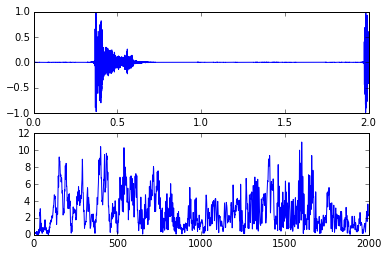

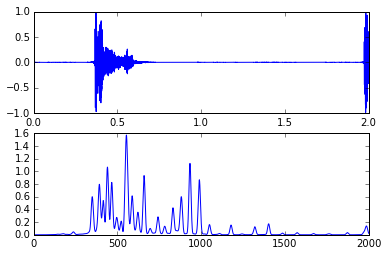

In [99]:
alldata = np.hstack(frames)
alldata.shape
fs=8192
yt = alldata[2*fs:4*fs] / 2**15
yf, ff = PianoFFT(yt, fs=fs)
yf, ff = PianoWelch(yt, fs=fs)
